In [1]:
from eps_seg.dataloaders.datasets import PredictionDataset
from torch.utils.data import DataLoader
from eps_seg.models.lvae import LVAEModel
from eps_seg.config.train import ExperimentConfig
import torch
import numpy as np
from pathlib import Path
import tifffile
import tqdm

In [2]:
MODE = "supervised"  # "supervised" or "semisupervised"
Z_SLICE = 626
exp_config = ExperimentConfig.from_yaml("/home/sheida.rahnamai/GIT/eps-Seg/experiments/dev/exp_margin_50.yaml")
train_config, dataset_config, model_config = exp_config.get_configs()

Loaded training config from /home/sheida.rahnamai/GIT/eps-Seg/experiments/dev/train.yaml
Loaded model config from /home/sheida.rahnamai/GIT/eps-Seg/experiments/dev/model_2D.yaml


In [3]:
def dice_per_class(pred, gt, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.int16)
        gt_cls = (gt == cls).astype(np.int16)
        intersection = np.sum(pred_cls & gt_cls)
        union = np.sum(pred_cls) + np.sum(gt_cls)
        if union == 0:
            dice = 1.0  # Both pred and gt are empty
        else:
            dice = (2.0 * intersection) / union
        dice_scores.append(dice)
    return dice_scores

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LVAEModel.load_from_checkpoint(exp_config.best_checkpoint_path(MODE),
                                       model_cfg=model_config,
                                       train_cfg=train_config).to(device)
model.eval();
model.update_mode(MODE)

Loaded training config from /home/sheida.rahnamai/GIT/eps-Seg/experiments/dev/train.yaml
Loaded model config from /home/sheida.rahnamai/GIT/eps-Seg/experiments/dev/model_2D.yaml
Updating model training mode to: supervised
Updating model mode from supervised to supervised
Updating TopDownLayer mode from supervised to supervised
Updating TopDownLayer mode from supervised to supervised
Updating TopDownLayer mode from supervised to supervised


# TEST on Test Slice

In [5]:

# Data loading
CROP=True
crop_slice_x = slice(400, 600)
crop_slice_y = slice(200, 400)


k = dataset_config.test_keys[0]
test_img_tiff = tifffile.imread(dataset_config.data_dir / Path(k) / f"{k}_source.tif").astype("float16")
test_gt_tiff = tifffile.imread(dataset_config.data_dir / Path(k) / f"{k}_gt.tif").astype("float16")

if CROP:
    test_img_tiff = test_img_tiff[:, crop_slice_y, crop_slice_x]
    test_gt_tiff = test_gt_tiff[:, crop_slice_y, crop_slice_x]

pred_dataset = DataLoader(
        PredictionDataset(
            test_img_tiff,
            test_gt_tiff,
            z = Z_SLICE,
        ),
        batch_size=1024,
        shuffle=False,
    )

In [6]:
import tqdm
out_slice = (np.zeros_like(test_gt_tiff[Z_SLICE]) - 1).astype(np.int16)
mu = model.model.data_mean
std = model.model.data_std

for batch in tqdm.tqdm(pred_dataset):
    x = ((batch["patch"].to(device) - mu) / std)
    with torch.no_grad():
        pred_dict = model(x=x)
        pred = torch.argmax(pred_dict["class_probabilities"], dim=-1).to(torch.int16).cpu().numpy()
        out_slice[batch["y"], batch["x"]] = pred

  0%|          | 0/19 [00:00<?, ?it/s]/home/sheida.rahnamai/GIT/eps-Seg/.venv/lib64/python3.11/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/sheida.rahnamai/GIT/eps-Seg/.venv/lib64/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 19/19 [00:23<00:00,  1.24s/it]


In [7]:
gt_crop = test_gt_tiff[Z_SLICE][32:-33,32:-33]
out_crop = out_slice[32:-33,32:-33]
dice_scores = dice_per_class(out_crop, gt_crop, 4)

In [8]:
avg_dsc = 0
for d in dice_scores:
    avg_dsc += d
avg_dsc /= len(dice_scores)
avg_dsc

np.float64(0.72913344906935)

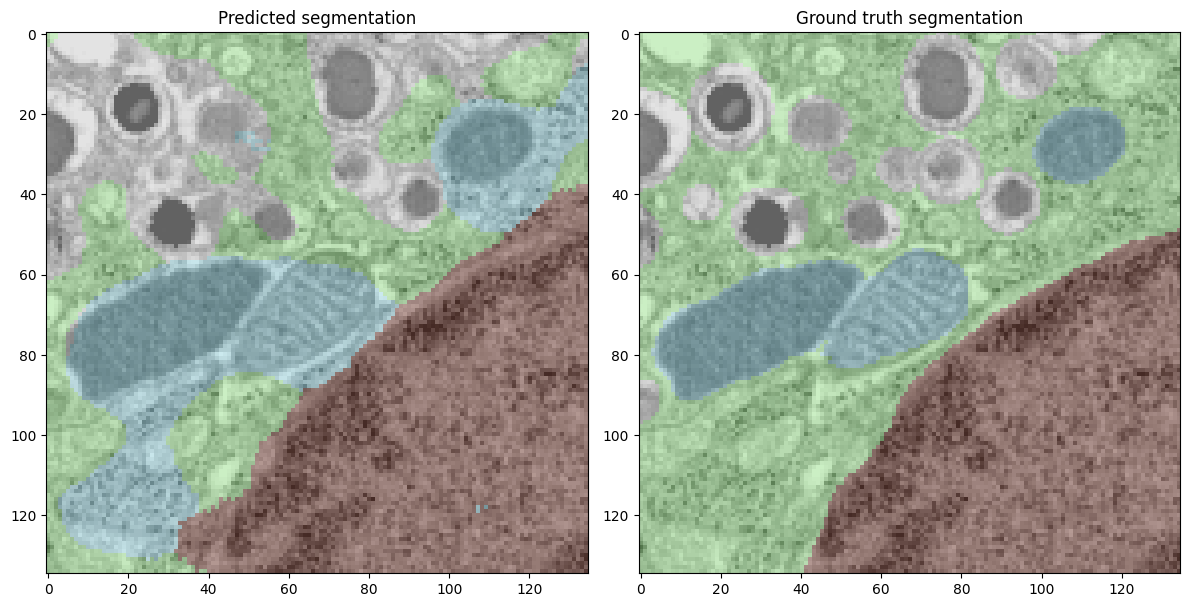

In [9]:
import matplotlib.pyplot as plt
alpha = .5
num_classes = 4
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_img_tiff[Z_SLICE][32:-33,32:-33], cmap="gray")
plt.imshow(out_crop, cmap="tab20", alpha=alpha, vmin=-1, vmax=num_classes-1)
plt.title("Predicted segmentation")
plt.subplot(1, 2, 2)
plt.imshow(test_img_tiff[Z_SLICE][32:-33,32:-33], cmap="gray")
plt.imshow(gt_crop, cmap="tab20", alpha=alpha,  vmin=-1, vmax=num_classes-1)
plt.title("Ground truth segmentation")
plt.tight_layout()

In [10]:
num_classes =  4
dice_scores = dice_per_class(out_crop, gt_crop, num_classes)
print(dice_scores)


[np.float64(0.6276587206035797), np.float64(0.9500705716302047), np.float64(0.6858290836037707), np.float64(0.6529754204398448)]


# TEST on Train Dataset

In [11]:
from eps_seg.dataloaders.datamodules import BetaSegTrainDataModule

train_dm = BetaSegTrainDataModule(
    cfg=dataset_config,
    train_cfg=train_config)
train_dm.setup("predict")

Loading cached dataset splits from /group/jug/edoardo/datasets/eps_seg/cache/pancreatic_beta_cells/...
Loaded cached dataset splits from /group/jug/edoardo/datasets/eps_seg/cache/pancreatic_beta_cells/.
  Class 0 (anchors): 2589 samples
  Class 1 (anchors): 2450 samples
  Class 2 (anchors): 2522 samples
  Class 3 (anchors): 2468 samples
  Class 0 (neighbors): 23292 samples
  Class 1 (neighbors): 16816 samples
  Class 2 (neighbors): 15388 samples
  Class 3 (neighbors): 14707 samples
  Class 0 (anchors): 457 samples
  Class 1 (anchors): 456 samples
  Class 2 (anchors): 450 samples
  Class 3 (anchors): 436 samples
  Class 0 (neighbors): 4103 samples
  Class 1 (neighbors): 3126 samples
  Class 2 (neighbors): 2739 samples
  Class 3 (neighbors): 2625 samples


In [12]:
preds = []
gts = []
for batch in tqdm.tqdm(train_dm.train_dataloader()):
    x, y, _, asd = batch
    # x = ((x.to(device) - mu) / std)
    with torch.no_grad():
        pred_dict = model(x=x.float().to(device))
        pred = torch.argmax(pred_dict["class_probabilities"], dim=-1).to(torch.int16).cpu().numpy()
        preds.append(pred)
        gts.append(y.numpy())
preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


In [13]:
dice_per_class(preds, gts, num_classes=4)

[np.float64(0.7567888999008919),
 np.float64(0.9867405501682169),
 np.float64(0.7957405614714425),
 np.float64(0.9062679700977573)]

In [14]:
preds = []
gts = []
for batch in tqdm.tqdm(train_dm.val_dataloader()):
    x, y, _, asd = batch
    # x = ((x.to(device) - mu) / std)
    with torch.no_grad():
        pred_dict = model(x=x.float().to(device))
        pred = torch.argmax(pred_dict["class_probabilities"], dim=-1).to(torch.int16).cpu().numpy()
        preds.append(pred)
        gts.append(y.numpy())
preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


In [15]:
dice_per_class(preds, gts, num_classes=4)

[np.float64(0.7351129363449692),
 np.float64(0.9682539682539683),
 np.float64(0.7992277992277992),
 np.float64(0.8905380333951762)]